In [1]:
from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI , GoogleGenerativeAIEmbeddings

load_dotenv()

True

In [2]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
llm = ChatGoogleGenerativeAI(model="models/gemini-2.5-flash")

In [3]:
print(llm.invoke("Hey , who are you ??"))
print(embeddings.embed_query("Hey , who are you ??"))

content='I am a large language model, trained by Google.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--ba39f998-2fc6-48a6-93d9-6eb707cfa2c8-0' usage_metadata={'input_tokens': 7, 'output_tokens': 48, 'total_tokens': 55, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 37}}
[-0.007657204754650593, -0.03650370240211487, -0.047206588089466095, -0.020650196820497513, 0.020582176744937897, 0.02473335713148117, 0.03401658311486244, 0.024470049887895584, -0.013394668698310852, 0.03104269877076149, -0.021255671977996826, 0.022455960512161255, 0.10696950554847717, -0.02052895538508892, -0.018678538501262665, -0.03552921861410141, 0.01856077089905739, 0.041322413831949234, -0.09512614458799362, -0.012002947740256786, 0.01836177334189415, -0.023864468559622765,

In [5]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [6]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [8]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

In [9]:
from langchain_chroma import Chroma

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embeddings
)

retriever = vectorstore.as_retriever()

In [10]:
from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [11]:
retriever_tool.invoke({"query": "types of reward hacking"})

'In-Context Reward Hacking#\n\nWhy does Reward Hacking Exist?#\n\nDetecting Reward Hacking#\n\nAmodei et al. (2016) summarized that reward hacking, mainly in RL setting, may occur due to:'

In [12]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = ChatGoogleGenerativeAI(model="models/gemini-2.5-flash")


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [13]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I help you today?


In [14]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (b7a45fbe-451f-4087-8df3-63f700e24948)
 Call ID: b7a45fbe-451f-4087-8df3-63f700e24948
  Args:
    query: Lilian Weng reward hacking types


In [16]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = ChatGoogleGenerativeAI(model="models/gemini-2.5-flash")


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [17]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [18]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

In [19]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [20]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

How does Lilian Weng categorize or classify different forms of reward hacking in her discussions on AI safety and alignment?


In [21]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [23]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't know what Lilian Weng says about types of reward hacking based on the provided context. The context states that reward hacking can be categorized into environment or goal misspecification, and reward tampering, but it does not attribute this statement to Lilian Weng.


In [24]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

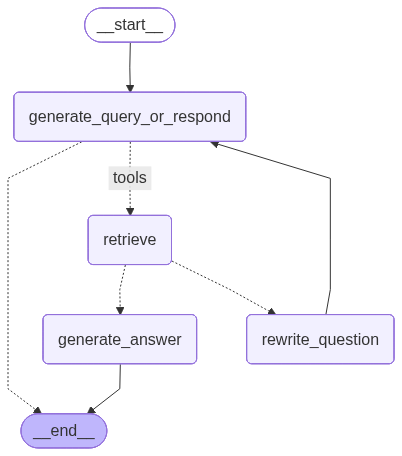

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (ac1695e5-9fcb-4f24-a719-8fd8936db0bc)
 Call ID: ac1695e5-9fcb-4f24-a719-8fd8936db0bc
  Args:
    query: Lilian Weng reward hacking types



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2024",
  month   = "Nov",
  url     = "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/"
}
References#

In-Context Reward Hacking#

Detecting Reward Hacking#

Hacking RL Environment#



Update from node generate_answer
================================== Ai Message ==================================

Lilian Weng discusses "In-Context Reward Hacking" as a specific area. Her work also addresses "Hacking RL Environment" within the broader topic of reward hacking.



